Enter activity levels for each room and time block (0.0 to 1.0):

 Time Block: Morning


→ Activity level for 'Living_Room' during Morning (0.0 to 1.0):  0.5
→ Activity level for 'Kitchen' during Morning (0.0 to 1.0):  0.3
→ Activity level for 'Room' during Morning (0.0 to 1.0):  0.1
→ Activity level for 'Bedroom' during Morning (0.0 to 1.0):  0.8
→ Activity level for 'Toilet' during Morning (0.0 to 1.0):  0.3
→ Activity level for 'Bathroom' during Morning (0.0 to 1.0):  0.04
→ Activity level for 'Gym' during Morning (0.0 to 1.0):  0.58



 Time Block: Afternoon


→ Activity level for 'Living_Room' during Afternoon (0.0 to 1.0):  0.68
→ Activity level for 'Kitchen' during Afternoon (0.0 to 1.0):  0.95
→ Activity level for 'Room' during Afternoon (0.0 to 1.0):  0.87
→ Activity level for 'Bedroom' during Afternoon (0.0 to 1.0):  0.44
→ Activity level for 'Toilet' during Afternoon (0.0 to 1.0):  0.63
→ Activity level for 'Bathroom' during Afternoon (0.0 to 1.0):  0.24
→ Activity level for 'Gym' during Afternoon (0.0 to 1.0):  0.42



 Time Block: Evening


→ Activity level for 'Living_Room' during Evening (0.0 to 1.0):  0.28
→ Activity level for 'Kitchen' during Evening (0.0 to 1.0):  0.834
→ Activity level for 'Room' during Evening (0.0 to 1.0):  0.285
→ Activity level for 'Bedroom' during Evening (0.0 to 1.0):  0.853
→ Activity level for 'Toilet' during Evening (0.0 to 1.0):  0.829
→ Activity level for 'Bathroom' during Evening (0.0 to 1.0):  0.988
→ Activity level for 'Gym' during Evening (0.0 to 1.0):  0.480



 Time Block: Night


→ Activity level for 'Living_Room' during Night (0.0 to 1.0):  0.843
→ Activity level for 'Kitchen' during Night (0.0 to 1.0):  0.985
→ Activity level for 'Room' during Night (0.0 to 1.0):  0.444
→ Activity level for 'Bedroom' during Night (0.0 to 1.0):  0.222
→ Activity level for 'Toilet' during Night (0.0 to 1.0):  0.555
→ Activity level for 'Bathroom' during Night (0.0 to 1.0):  1
→ Activity level for 'Gym' during Night (0.0 to 1.0):  0



 Final activity level configuration:
{'Afternoon': {'Bathroom': 0.24,
               'Bedroom': 0.44,
               'Gym': 0.42,
               'Kitchen': 0.95,
               'Living_Room': 0.68,
               'Room': 0.87,
               'Toilet': 0.63},
 'Evening': {'Bathroom': 0.988,
             'Bedroom': 0.853,
             'Gym': 0.48,
             'Kitchen': 0.834,
             'Living_Room': 0.28,
             'Room': 0.285,
             'Toilet': 0.829},
 'Morning': {'Bathroom': 0.04,
             'Bedroom': 0.8,
             'Gym': 0.58,
             'Kitchen': 0.3,
             'Living_Room': 0.5,
             'Room': 0.1,
             'Toilet': 0.3},
 'Night': {'Bathroom': 1.0,
           'Bedroom': 0.222,
           'Gym': 0.0,
           'Kitchen': 0.985,
           'Living_Room': 0.843,
           'Room': 0.444,
           'Toilet': 0.555}}


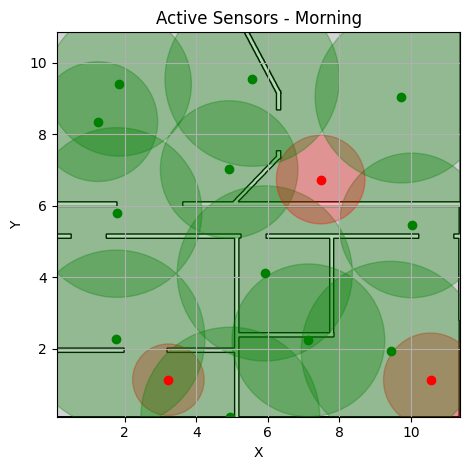

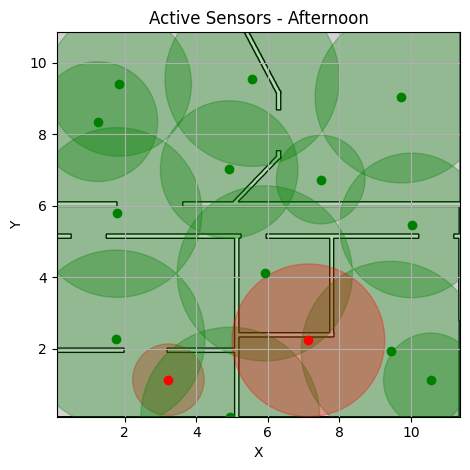

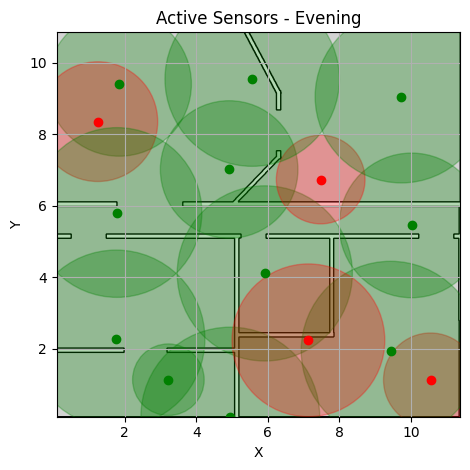

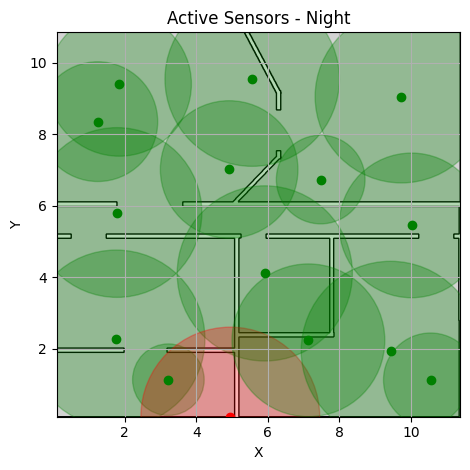

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.collections import PatchCollection

# ------------ Load Layout and Sensor Data ------------
with open("layout.json", "r") as f:
    layout_data = json.load(f)

polygon_coords = layout_data["verts"]
room_boxes = layout_data["room_category"]
min_x, min_y = layout_data["bbox"]["min"]
max_x, max_y = layout_data["bbox"]["max"]

# Load sensor placement from Phase 1 output
with open("phase1_sensors.json", "r") as f:
    sensor_data = json.load(f)

sensor_positions = np.array(sensor_data["sensors"])  # each is (x, y, r)

# ------------ Dynamic Activity Levels Prompt ------------
import pprint

time_blocks = ["Morning", "Afternoon", "Evening", "Night"]
room_categories = layout_data.get("room_category", {}).keys()

# Initialize activity_levels dictionary
activity_levels = {time: {} for time in time_blocks}

print("Enter activity levels for each room and time block (0.0 to 1.0):")
for time in time_blocks:
    print(f"\n Time Block: {time}")
    for room in room_categories:
        while True:
            try:
                val = float(input(f"→ Activity level for '{room}' during {time} (0.0 to 1.0): "))
                if 0.0 <= val <= 1.0:
                    activity_levels[time][room] = val
                    break
                else:
                    print("Value must be between 0.0 and 1.0.")
            except ValueError:
                print("Invalid input. Please enter a number.")

print("\n Final activity level configuration:")
pprint.pprint(activity_levels)


time_periods = list(activity_levels.keys())

# ------------ Assign Room Labels to Grid Points ------------
grid_resolution = 0.2
x_coords = np.arange(min_x, max_x, grid_resolution)
y_coords = np.arange(min_y, max_y, grid_resolution)
xx, yy = np.meshgrid(x_coords, y_coords)
GRID = np.c_[xx.ravel(), yy.ravel()]

room_label_map = np.full(len(GRID), "None", dtype=object)
for room_name, boxes in room_boxes.items():
    for box in boxes:
        x1, y1, x2, y2 = box
        in_room = (GRID[:, 0] >= x1) & (GRID[:, 0] <= x2) & (GRID[:, 1] >= y1) & (GRID[:, 1] <= y2)
        room_label_map[in_room] = room_name

# ------------ Phase 2: Optimize Sensor Activation ------------
def evaluate_sensor_activation(sensor_mask, time_key):
    coverage = np.zeros(len(GRID))
    for i, active in enumerate(sensor_mask):
        if not active:
            continue
        x_s, y_s, r = sensor_positions[i]
        dist = np.hypot(GRID[:, 0] - x_s, GRID[:, 1] - y_s)
        cover_mask = dist <= r
        coverage += cover_mask.astype(float)

    # Apply room-based activity weighting
    weights = np.array([activity_levels[time_key].get(room, 0.0) for room in room_label_map])
    score = np.sum((coverage > 0) * weights)
    cost = np.sum(sensor_mask)  # active sensors
    return score, cost

# Brute-force binary optimization using random restarts (or you can use GA/DE)
def optimize_activation_for_time(time_key, trials=1000):
    best_score = -np.inf
    best_mask = None
    best_cost = None
    N = len(sensor_positions)

    for _ in range(trials):
        mask = np.random.rand(N) > 0.5
        score, cost = evaluate_sensor_activation(mask, time_key)
        if score > best_score:
            best_score = score
            best_mask = mask.copy()
            best_cost = cost

    return best_mask, best_score, best_cost

# ------------ Run Optimization for All Time Periods ------------
phase2_results = {}
for period in time_periods:
    mask, score, cost = optimize_activation_for_time(period)
    phase2_results[period] = {
        "active_mask": mask.tolist(),
        "score": float(score),
        "active_sensor_count": int(cost)
    }

# ------------ Save Results ------------
with open("phase2_results.json", "w") as f:
    json.dump(phase2_results, f, indent=2)

# ------------ Visualization per Time Period ------------
for period in time_periods:
    active_mask = np.array(phase2_results[period]["active_mask"])
    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    ax.set_title(f"Active Sensors - {period}")
    ax.add_patch(Polygon(polygon_coords, closed=True, edgecolor='black', facecolor='lightgray', linewidth=1))

    for i, active in enumerate(active_mask):
        x, y, r = sensor_positions[i]
        color = "green" if active else "red"
        ax.add_patch(plt.Circle((x, y), r, color=color, alpha=0.3))
        ax.plot(x, y, "go" if active else "ro")

    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()
